<a href="https://colab.research.google.com/github/Sihan-A/PyTorch_Learning_Notebook/blob/main/GSDWP_04_First_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Runtime` -> `Change runtime type` -> `GPU`

# 2 First Neural Network with PyTorch

## 准备

In [1]:
# 安装watermark
!pip install -q -U watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy : 1.19.5
pandas: 1.1.5
torch : 1.9.0+cu102



In [3]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00",
                        "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams["figure.figsize"] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data

In [5]:
# 数据
url = "https://raw.githubusercontent.com/Sihan-A/PyTorch_Learning_Notebook/main/data/weatherAUS.csv"
# csv -> pands DataFrame
df = pd.read_csv(url)
# 查看前5行
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
# 形状
df.shape

(145460, 23)

- 145460样本
- 23特征

In [7]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## Data Preprocessing

In [9]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']
df = df[cols]

In [10]:
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


In [11]:
df["RainToday"].replace({"No": 0, "Yes": 1}, inplace=True)
df["RainTomorrow"].replace({"No": 0, "Yes": 1}, inplace=True)

In [12]:
df = df.dropna(how="any")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124689 entries, 0 to 145458
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Rainfall      124689 non-null  float64
 1   Humidity3pm   124689 non-null  float64
 2   Pressure9am   124689 non-null  float64
 3   RainToday     124689 non-null  float64
 4   RainTomorrow  124689 non-null  float64
dtypes: float64(5)
memory usage: 5.7 MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


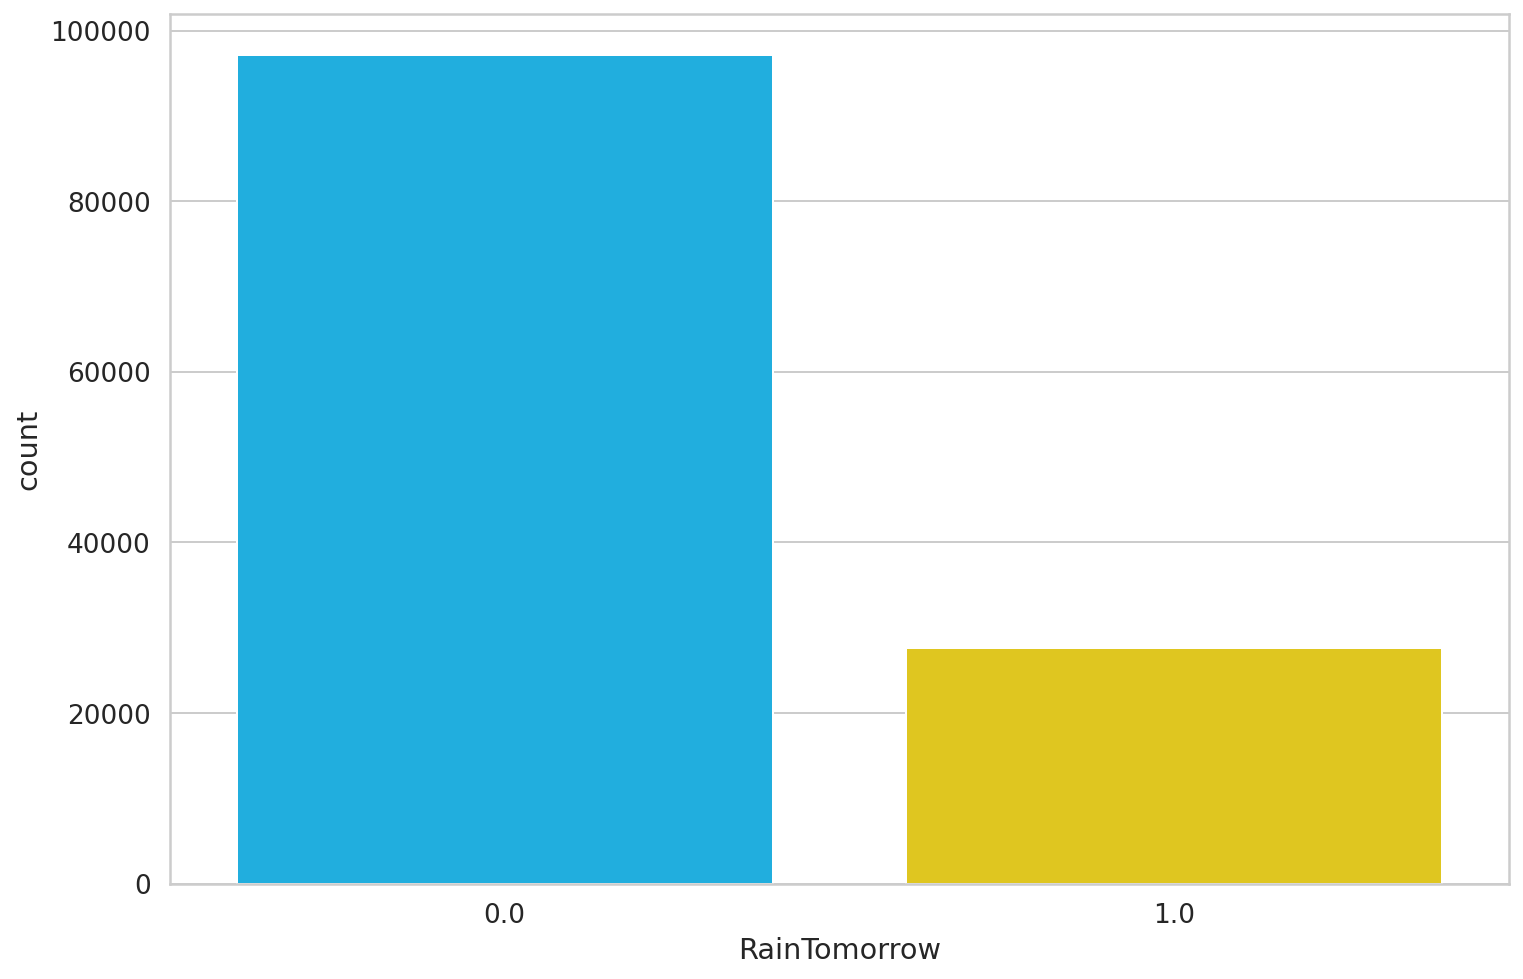

In [14]:
sns.countplot(df.RainTomorrow)

In [15]:
df.RainTomorrow.value_counts() / df.shape[0]

0.0    0.778762
1.0    0.221238
Name: RainTomorrow, dtype: float64

imbalanced data!!!

In [16]:
X = df.drop("RainTomorrow", axis=1)
y = df["RainTomorrow"]

In [17]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [18]:
# 转为tensor
X_train = torch.from_numpy(X_train.to_numpy()).float()
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()
y_test = torch.from_numpy(y_test.to_numpy()).float()

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


## Building a Neural Network

In [20]:
class Net(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [21]:
net = Net(X_train.shape[1])

## Training

In [30]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## GPU

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [32]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true==predicted).sum().float() / len(y_true)

In [41]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [42]:
for epoch in range(1_000):
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        y_test_pred = net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred, y_test)
        test_acc = calculate_accuracy(y_test, y_test_pred)
        print(
            f'''epoch {epoch}
            Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
            ''')
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0
            Train set - loss: 10.594, accuracy: 0.221
            Test  set - loss: 10.589, accuracy: 0.222
            
epoch 100
            Train set - loss: 0.408, accuracy: 0.83
            Test  set - loss: 0.408, accuracy: 0.831
            
epoch 200
            Train set - loss: 0.403, accuracy: 0.834
            Test  set - loss: 0.402, accuracy: 0.837
            
epoch 300
            Train set - loss: 0.402, accuracy: 0.834
            Test  set - loss: 0.401, accuracy: 0.836
            
epoch 400
            Train set - loss: 0.402, accuracy: 0.834
            Test  set - loss: 0.401, accuracy: 0.836
            
epoch 500
            Train set - loss: 0.402, accuracy: 0.833
            Test  set - loss: 0.401, accuracy: 0.836
            
epoch 600
            Train set - loss: 0.402, accuracy: 0.833
            Test  set - loss: 0.4, accuracy: 0.836
            
epoch 700
            Train set - loss: 0.401, accuracy: 0.833
            Test  set - loss: 0.4, ac

## Saving the model